# AirFrance Hackathon

### Gabriel A. Moreira

In [689]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import AveragePooling1D
from keras.utils import to_categorical
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import random
from tensorflow import keras

df_train = pd.read_csv('/home/gabriel/Desktop/hackathonAirFrance-master/data/train_data.csv', sep=',')
df_test = pd.read_csv('/home/gabriel/Desktop/hackathonAirFrance-master/data/test_data.csv', sep=',')

## Data generation functions

In [591]:
def normalize_df(df):
    new_df = df.copy(deep=True)
    for i in range(df.shape[1]):
        if i >= 1 and i < 26:
            x = new_df.iloc[:,i]
            new_df.iloc[:,i] = (x-min(x))/(max(x)-min(x)) - 0.5
    new_df.drop(new_df.columns[26:32], axis=1, inplace=True)
    new_df.drop(new_df.columns[1], axis=1, inplace=True)
    return new_df

def get_engine_data(df, engine, test=False, normalized=True):
    df_copy = df.copy(deep=True)
    df = normalize_df(df_copy)
    
    if not test:
        X_data = df.loc[df['engine_no'] == engine].iloc[:,1:-1]
        Y_data = df.loc[df['engine_no'] == engine].iloc[:,-1]
        return [X_data.reset_index(drop=True), Y_data.reset_index(drop=True)]
    else:
        X_data = df.loc[df['engine_no'] == engine].iloc[:,1:]
        return X_data.reset_index(drop=True)
      
def generate_train_dataset(df, SEQUENCE_LENGTH):
    x = []
    y = []
    N_ENGINES = int(max(set(df['engine_no']))) + 1
    for engine in range(N_ENGINES):
        if engine % 100 == 0:
            print(engine)
        rule = [True, False]
        slice_to_fail = random.choice(rule)
        df_eng = df.loc[df['engine_no'] == engine]
        df_eng.reset_index(drop=True, inplace=True)
        total_length = df_eng.shape[0]
             
        if total_length > 100 + SEQUENCE_LENGTH:
            if slice_to_fail:
                for _ in range(15):
                    offset = random.choice(np.arange(100))
                    total_length = df_eng.shape[0]
                    seq_df = df_eng[total_length-SEQUENCE_LENGTH-offset:total_length-offset]
                    seq_df = seq_df.reset_index(drop=True)
                    y.append(1)
                    seq_df.drop(seq_df.columns[0], axis=1, inplace=True)
                    seq_df.drop(seq_df.columns[-1], axis=1, inplace=True)
                    x.append(seq_df)
            else:
                for _ in range(15):
                    total_length = df_eng.shape[0]
                    offset = random.choice(np.arange(total_length-100-SEQUENCE_LENGTH))
                    seq_df = df_eng[offset:SEQUENCE_LENGTH + offset]
                    seq_df = seq_df.reset_index(drop=True)
                    y.append(0)
                    seq_df.drop(seq_df.columns[0], axis=1, inplace=True)
                    seq_df.drop(seq_df.columns[-1], axis=1, inplace=True)
                    x.append(seq_df)
    return x, y

In [609]:
SEQUENCE_LEN = 90
df = normalize_df(df_train)
x, y = generate_train_dataset(df, SEQUENCE_LEN)

0
100
200
300
400
500
600
700


In [610]:
N_FEATURES = x[0].shape[1]
split_size = 0.7
combined = list(zip(x, y))
random.shuffle(combined)

x[:], y[:] = zip(*combined)

train_indices = random.sample(range(len(x)), int(split_size*len(x)))
test_indices = [i for i in range(len(x)) if i not in train_indices]

trainX = np.empty((len(train_indices), SEQUENCE_LEN, N_FEATURES))
testX = np.empty((len(test_indices), SEQUENCE_LEN, N_FEATURES))
trainy = np.empty((len(train_indices), 1))
testy = np.empty((len(test_indices), 1))

In [611]:
ii = sorted(train_indices)

for i in range(len(train_indices)):
    trainX[i,:,:] = x[ii[i]].values.reshape(SEQUENCE_LEN,N_FEATURES)
    trainy[i,0] = y[ii[i]]

for i in range(len(test_indices)):
    testX[i,:,:] = x[ii[i]].values.reshape(SEQUENCE_LEN,N_FEATURES)
    testy[i,0] = y[ii[i]]
    
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In [612]:
trainX.shape

(4966, 90, 24)

In [781]:
def learn(trainX, trainy):
    verbose, epochs, batch_size = 1, 90, 128
    n_steps, n_length = 9, 10

    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], 2
    trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
    
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'), 
                              input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=50, kernel_size=5, activation='relu')))
    model.add(TimeDistributed(Dropout(0.3)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)
    
    return model, history

def run_training(trainX, trainy, testX, testy):
    batch_size = 128
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], 2
    n_steps, n_length = 9, 10
    
    testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
    
    model, history = learn(trainX, trainy)
    
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
    score = accuracy * 100.0
    print('> Test accuracy: %.3f' % score)
    return model, history

## Recursive Neural Network - LSTM implementation with Keras

### Training the model

In [811]:
model, history = run_training(trainX, trainy, testX, testy)

Train on 3972 samples, validate on 994 samples
Epoch 1/90
3972/3972 [==============================] - 30s 8ms/step - loss: 0.7158 - acc: 0.4982 - val_loss: 0.6942 - val_acc: 0.4940
Epoch 2/90
3972/3972 [==============================] - 1s 256us/step - loss: 0.6989 - acc: 0.5189 - val_loss: 0.6957 - val_acc: 0.4950
Epoch 3/90
3972/3972 [==============================] - 1s 243us/step - loss: 0.6928 - acc: 0.5322 - val_loss: 0.6889 - val_acc: 0.5322
Epoch 4/90
3972/3972 [==============================] - 1s 252us/step - loss: 0.6899 - acc: 0.5365 - val_loss: 0.6937 - val_acc: 0.4909
Epoch 5/90
3972/3972 [==============================] - 1s 256us/step - loss: 0.6850 - acc: 0.5400 - val_loss: 0.6749 - val_acc: 0.5684
Epoch 6/90
3972/3972 [==============================] - 1s 256us/step - loss: 0.6699 - acc: 0.5836 - val_loss: 0.6504 - val_acc: 0.5895
Epoch 7/90
3972/3972 [==============================] - 1s 244us/step - loss: 0.6162 - acc: 0.6488 - val_loss: 0.6490 - val_acc: 0.5895
Ep

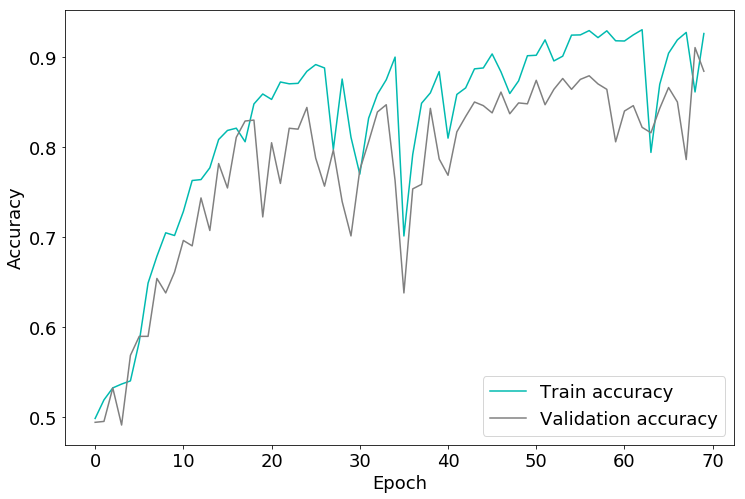

In [819]:
acc = history.history['acc']
valacc = history.history['val_acc']
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,8))
plt.plot(acc, c='#00bab0', markersize=4)
plt.plot(valacc, c='gray')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy', 'Validation accuracy'])

## Save results to .csv file

In [749]:
res = pd.DataFrame()
res['engine_no'] = list(range(0,707))

rr = np.asarray(final_binary_classif, dtype=int)
res['result'] = rr
res.to_csv('submission.csv', sep=',', encoding='utf-8', index=False)

In [754]:
for i in np.arange(707):
    if i not in engines:
        print(i)

6
10
33
36
38
39
49
50
61
62
63
65
66
70
72
73
74
77
85
86
89
94
95
96
99
108
112
116
130
132
144
149
155
159
163
164
167
168
170
181
186
189
191
193
195
196
201
211
213
223
225
227
228
230
232
233
241
242
244
247
249
251
252
256
262
267
276
280
289
290
297
304
305
308
311
313
320
324
328
329
330
332
334
335
336
343
350
352
354
355
359
362
365
366
369
370
371
372
374
376
378
379
384
390
392
393
399
400
403
404
405
414
421
424
431
436
440
449
452
453
458
460
463
464
467
468
469
470
471
474
475
477
480
482
485
493
499
503
509
510
512
513
515
534
537
543
552
558
560
562
563
568
580
585
593
594
599
600
608
615
617
626
630
634
635
636
638
645
646
648
656
661
662
663
677
678
692
694
700
701
702
703
